In [1]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# PyTorch related imports would go here
import numpy as np

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from us import states
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re

In [3]:
state_names = [state.name.lower() for state in states.STATES]
state_abbrs = [state.abbr for state in states.STATES]
city_df = pd.read_csv('PM25-Speciated/worldcities.csv')
city_names = city_df['city_ascii'].str.lower().tolist()  # First column
country_names = city_df['country'].str.lower().tolist()  # First column

In [4]:
stop_words = TfidfVectorizer(stop_words='english').get_stop_words()
stop_words = list(list(stop_words)+ city_names + country_names + state_names + state_abbrs)

# Original Data

In [5]:
# #DATASET_NAME = "SpeciateV5.3_PM_AE6.csv"
# DATASET_NAME = "SpeciateV5.3_PM_All.csv"
# df = pd.read_csv('PM25-Speciated/specviate_v5_3datasets/'+DATASET_NAME, encoding='ISO-8859-1')

In [6]:
DATASET_NAME = "PM_AE6_v5.3_v10182024.csv"
# DATASET_NAME = "PM_ALL2.5um_v5.3_v10182024.csv"
df = pd.read_csv('PM25-Speciated/reviseddatasetwithtotalocandec/'+DATASET_NAME, encoding='ISO-8859-1')

In [7]:
df

,PROFILE_CODE,PROFILE_NAME,PROFILE_TYPE,CONTROLS,REGION,MASTER_POLLUTANT,TOTAL,QSCORE,QSCORE_DESC,QUALITY,...,CATEGORY_LEVEL_2_Sector_Equipment,CATEGORY_LEVEL_3_ Fuel_Product,SPECIES_ID,CAS,SPECIES_NAME,WEIGHT_PERCENT,INCLUDE_IN_SUM,UNCERTAINTY_PERCENT,SPEC_MW,Data_Origin
0,3766AE6,Forest Fire - AE6,PM-AE6,Uncontrolled,Northwestern Colorado,PM,100.0,26.0,Excellent,C,...,Biomass Burning; Wildfire,Pinyon-juniper,2302,24203-36-9,Potassium ion,0.120300,Yes,0.095900,39.097800,DRI
1,3766AE6,Forest Fire - AE6,PM-AE6,Uncontrolled,Northwestern Colorado,PM,100.0,26.0,Excellent,C,...,Biomass Burning; Wildfire,Pinyon-juniper,767,7440-62-2,Vanadium,0.000100,Yes,0.000200,50.941500,DRI
2,3766AE6,Forest Fire - AE6,PM-AE6,Uncontrolled,Northwestern Colorado,PM,100.0,26.0,Excellent,C,...,Biomass Burning; Wildfire,Pinyon-juniper,696,7440-23-5,Sodium,0.012200,Yes,0.013000,22.989769,DRI
3,3766AE6,Forest Fire - AE6,PM-AE6,Uncontrolled,Northwestern Colorado,PM,100.0,26.0,Excellent,C,...,Biomass Burning; Wildfire,Pinyon-juniper,699,14808-79-8,Sulfate,0.133200,Yes,0.062900,96.060000,DRI
4,3766AE6,Forest Fire - AE6,PM-AE6,Uncontrolled,Northwestern Colorado,PM,100.0,26.0,Excellent,C,...,Biomass Burning; Wildfire,Pinyon-juniper,700,7704-34-9,Sulfur,0.079200,No,0.021300,32.060000,DRI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,PM-AE6,NaN,"Mexico - Chiapas, Jalisco, Veracruz, and Morelos",PM,100.0,19.5,Good,A,...,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,613,14797-55-8,Nitrate,0.168067,Yes,0.000000,62.005000,Literature
4454,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,PM-AE6,NaN,"Mexico - Chiapas, Jalisco, Veracruz, and Morelos",PM,100.0,19.5,Good,A,...,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,699,14808-79-8,Sulfate,3.361345,Yes,0.504202,96.060000,Literature
4455,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,PM-AE6,NaN,"Mexico - Chiapas, Jalisco, Veracruz, and Morelos",PM,100.0,19.5,Good,A,...,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,784,14798-03-9,Ammonium,2.184874,Yes,0.420168,18.038000,Literature
4456,SUGP02,Sugar Cane Pre-Harvest Burning Mexico,PM-AE6,NaN,"Mexico - Chiapas, Jalisco, Veracruz, and Morelos",PM,100.0,19.5,Good,A,...,Biomass Burning; Agriculture,Pre-harvest Sugar Cane,797,7440-44-0,Elemental Carbon,28.571429,Yes,7.563025,12.011000,Literature


In [8]:
df = df.pivot_table(index=['PROFILE_CODE', 'PROFILE_NAME'], columns='SPECIES_NAME', values='WEIGHT_PERCENT', aggfunc='first').reset_index()
# Fill NaN values with 0 (or any other value you prefer)
df = df.fillna(0)

In [9]:
df

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,3766AE6,Forest Fire - AE6,0.015400,0.110500,0.000500,0.000300,0.0,0.000100,0.369300,0.0,...,0.062000,0.012200,0.0,0.133200,0.0792,0.001500,0.001500,0.000100,0.002900,0.000000
1,5674,Marine Vessel - Main Engine - Heavy Fuel Oil,0.771625,0.000000,0.019000,0.000000,0.0,0.003958,0.259125,0.0,...,0.000000,0.000000,0.0,38.032500,0.0000,0.013281,0.005000,1.515625,0.018250,0.000000
2,5675AE6,Marine Vessel - Auxiliary Engine - Marine Gas ...,0.000000,0.000000,0.061466,0.000000,0.0,0.023641,1.912530,0.0,...,0.340426,0.000000,0.0,12.078014,0.0000,0.035461,0.014184,0.082742,0.200946,0.000000
3,8873AE6,Aircraft Exhaust,0.000000,1.791897,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,6.867400,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8898a,Outdoor Hydronic Heater- one stage updraft con...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.017300,0.010700,0.0,0.044100,0.0147,0.000000,0.000000,0.000000,0.007760,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,95870,Catalytic Woodstove Startup Wood Composite,0.000000,0.000000,0.001704,0.000111,0.0,0.006554,0.056238,0.0,...,0.026435,0.045670,0.0,0.417652,0.0000,0.010290,0.001487,0.000154,0.045448,0.000927
215,95871,Catalytic Woodstove Burn Phase Composite Birch,0.000000,0.000000,0.010937,0.000005,0.0,0.006001,0.024024,0.0,...,0.101690,0.021691,0.0,1.906428,0.0000,0.008238,0.000061,0.000311,0.183862,0.000196
216,95872,Catalytic Woodstove Burn Phase Composite Spruce,0.000355,0.000000,0.000725,0.000006,0.0,0.002385,0.043209,0.0,...,0.001333,0.003175,0.0,0.359246,0.0000,0.001160,0.000393,0.000060,0.032112,0.000267
217,95873,Catalytic Woodstove Burn Phase and Wood Composite,0.000149,0.000000,0.006648,0.000006,0.0,0.004483,0.032082,0.0,...,0.059540,0.013915,0.0,1.256611,0.0000,0.005265,0.000200,0.000206,0.120127,0.000226


In [10]:
def clean_text(text):
    # Remove numbers and special characters
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [11]:
# df['name'] = df['name'].apply(clean_text)

In [12]:
df

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,3766AE6,Forest Fire - AE6,0.015400,0.110500,0.000500,0.000300,0.0,0.000100,0.369300,0.0,...,0.062000,0.012200,0.0,0.133200,0.0792,0.001500,0.001500,0.000100,0.002900,0.000000
1,5674,Marine Vessel - Main Engine - Heavy Fuel Oil,0.771625,0.000000,0.019000,0.000000,0.0,0.003958,0.259125,0.0,...,0.000000,0.000000,0.0,38.032500,0.0000,0.013281,0.005000,1.515625,0.018250,0.000000
2,5675AE6,Marine Vessel - Auxiliary Engine - Marine Gas ...,0.000000,0.000000,0.061466,0.000000,0.0,0.023641,1.912530,0.0,...,0.340426,0.000000,0.0,12.078014,0.0000,0.035461,0.014184,0.082742,0.200946,0.000000
3,8873AE6,Aircraft Exhaust,0.000000,1.791897,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,6.867400,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8898a,Outdoor Hydronic Heater- one stage updraft con...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.017300,0.010700,0.0,0.044100,0.0147,0.000000,0.000000,0.000000,0.007760,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,95870,Catalytic Woodstove Startup Wood Composite,0.000000,0.000000,0.001704,0.000111,0.0,0.006554,0.056238,0.0,...,0.026435,0.045670,0.0,0.417652,0.0000,0.010290,0.001487,0.000154,0.045448,0.000927
215,95871,Catalytic Woodstove Burn Phase Composite Birch,0.000000,0.000000,0.010937,0.000005,0.0,0.006001,0.024024,0.0,...,0.101690,0.021691,0.0,1.906428,0.0000,0.008238,0.000061,0.000311,0.183862,0.000196
216,95872,Catalytic Woodstove Burn Phase Composite Spruce,0.000355,0.000000,0.000725,0.000006,0.0,0.002385,0.043209,0.0,...,0.001333,0.003175,0.0,0.359246,0.0000,0.001160,0.000393,0.000060,0.032112,0.000267
217,95873,Catalytic Woodstove Burn Phase and Wood Composite,0.000149,0.000000,0.006648,0.000006,0.0,0.004483,0.032082,0.0,...,0.059540,0.013915,0.0,1.256611,0.0000,0.005265,0.000200,0.000206,0.120127,0.000226


In [13]:
# numeric_cols = df.select_dtypes(include=[np.number]).columns
# text_cols = df.select_dtypes(include=[object]).columns

# print(text_cols)

# agg_funcs = {col: 'mean' for col in numeric_cols}
# agg_funcs.update({col: lambda x: np.random.choice(x) for col in text_cols if col != 'name'})

# pivot_df = df.groupby('name').agg(agg_funcs).reset_index()

In [14]:
# cols = list(pivot_df.columns)
# cols.insert(0, cols.pop(cols.index('code')))
# pivot_df = pivot_df[cols]
# pivot_df

In [15]:
pivot_df = df
pivot_df

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,3766AE6,Forest Fire - AE6,0.015400,0.110500,0.000500,0.000300,0.0,0.000100,0.369300,0.0,...,0.062000,0.012200,0.0,0.133200,0.0792,0.001500,0.001500,0.000100,0.002900,0.000000
1,5674,Marine Vessel - Main Engine - Heavy Fuel Oil,0.771625,0.000000,0.019000,0.000000,0.0,0.003958,0.259125,0.0,...,0.000000,0.000000,0.0,38.032500,0.0000,0.013281,0.005000,1.515625,0.018250,0.000000
2,5675AE6,Marine Vessel - Auxiliary Engine - Marine Gas ...,0.000000,0.000000,0.061466,0.000000,0.0,0.023641,1.912530,0.0,...,0.340426,0.000000,0.0,12.078014,0.0000,0.035461,0.014184,0.082742,0.200946,0.000000
3,8873AE6,Aircraft Exhaust,0.000000,1.791897,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,6.867400,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8898a,Outdoor Hydronic Heater- one stage updraft con...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.017300,0.010700,0.0,0.044100,0.0147,0.000000,0.000000,0.000000,0.007760,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,95870,Catalytic Woodstove Startup Wood Composite,0.000000,0.000000,0.001704,0.000111,0.0,0.006554,0.056238,0.0,...,0.026435,0.045670,0.0,0.417652,0.0000,0.010290,0.001487,0.000154,0.045448,0.000927
215,95871,Catalytic Woodstove Burn Phase Composite Birch,0.000000,0.000000,0.010937,0.000005,0.0,0.006001,0.024024,0.0,...,0.101690,0.021691,0.0,1.906428,0.0000,0.008238,0.000061,0.000311,0.183862,0.000196
216,95872,Catalytic Woodstove Burn Phase Composite Spruce,0.000355,0.000000,0.000725,0.000006,0.0,0.002385,0.043209,0.0,...,0.001333,0.003175,0.0,0.359246,0.0000,0.001160,0.000393,0.000060,0.032112,0.000267
217,95873,Catalytic Woodstove Burn Phase and Wood Composite,0.000149,0.000000,0.006648,0.000006,0.0,0.004483,0.032082,0.0,...,0.059540,0.013915,0.0,1.256611,0.0000,0.005265,0.000200,0.000206,0.120127,0.000226


In [17]:
pivot_df.iloc[:,2:49].head()

SPECIES_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,Chloride ion,Chlorine,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,0.015400,0.110500,0.000500,0.0003,0.0,0.000100,0.369300,0.0,0.207,0.0,...,0.062000,0.0122,0.0,0.133200,0.0792,0.001500,0.001500,0.000100,0.002900,0.0
1,0.771625,0.000000,0.019000,0.0000,0.0,0.003958,0.259125,0.0,0.000,0.0,...,0.000000,0.0000,0.0,38.032500,0.0000,0.013281,0.005000,1.515625,0.018250,0.0
2,0.000000,0.000000,0.061466,0.0000,0.0,0.023641,1.912530,0.0,0.000,0.0,...,0.340426,0.0000,0.0,12.078014,0.0000,0.035461,0.014184,0.082742,0.200946,0.0
3,0.000000,1.791897,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000,0.0,...,0.000000,0.0000,0.0,6.867400,0.0000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000,0.0,...,0.017300,0.0107,0.0,0.044100,0.0147,0.000000,0.000000,0.000000,0.007760,0.0


# Clustering based on numeric values

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter

In [19]:
def assign_cluster_name(cluster):
    names = pivot_df[pivot_df['speciated_cluster'] == cluster]['PROFILE_NAME']
    most_common_name = Counter(names).most_common(1)[0][0]
    return most_common_name

In [22]:
X = pivot_df.iloc[:, 2:49]
#scaler = StandardScaler()
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

In [23]:
X

SPECIES_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,Chloride ion,Chlorine,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,0.015400,0.110500,0.000500,0.000300,0.0,0.000100,0.369300,0.0,0.207000,0.0,...,0.062000,0.012200,0.0,0.133200,0.0792,0.001500,0.001500,0.000100,0.002900,0.000000
1,0.771625,0.000000,0.019000,0.000000,0.0,0.003958,0.259125,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,38.032500,0.0000,0.013281,0.005000,1.515625,0.018250,0.000000
2,0.000000,0.000000,0.061466,0.000000,0.0,0.023641,1.912530,0.0,0.000000,0.0,...,0.340426,0.000000,0.0,12.078014,0.0000,0.035461,0.014184,0.082742,0.200946,0.000000
3,0.000000,1.791897,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,6.867400,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.017300,0.010700,0.0,0.044100,0.0147,0.000000,0.000000,0.000000,0.007760,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.000000,0.000000,0.001704,0.000111,0.0,0.006554,0.056238,0.0,0.000000,0.0,...,0.026435,0.045670,0.0,0.417652,0.0000,0.010290,0.001487,0.000154,0.045448,0.000927
215,0.000000,0.000000,0.010937,0.000005,0.0,0.006001,0.024024,0.0,0.000000,0.0,...,0.101690,0.021691,0.0,1.906428,0.0000,0.008238,0.000061,0.000311,0.183862,0.000196
216,0.000355,0.000000,0.000725,0.000006,0.0,0.002385,0.043209,0.0,0.000000,0.0,...,0.001333,0.003175,0.0,0.359246,0.0000,0.001160,0.000393,0.000060,0.032112,0.000267
217,0.000149,0.000000,0.006648,0.000006,0.0,0.004483,0.032082,0.0,0.000000,0.0,...,0.059540,0.013915,0.0,1.256611,0.0000,0.005265,0.000200,0.000206,0.120127,0.000226


In [25]:
model = NMF(n_components=32, init='random', random_state=0, max_iter=1000)
W = model.fit_transform(X)
H = model.components_

# What features to use for clustering

In [26]:
# Assuming 'target' is the category column, and 'name' is the label
X = pivot_df.iloc[:, 2:49]
#X = W

# Hierarchical Clustering

## k-NN Graph Construction

In [27]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.sparse.linalg import svds

In [28]:
# Apply SVD to X
U, S, VT = svds(X.values, k=16)
X_svd = U @ np.diag(S) @ VT

In [29]:
X = X_svd

In [30]:
# Compute KNN

K = 3
knn = NearestNeighbors(n_neighbors=K)  # You can change the number of neighbors
knn.fit(X)
distances, indices = knn.kneighbors(X)

# Create a graph
G = nx.Graph()

# Add nodes with PROFILE_NAME as labels
for i, profile_name in enumerate(df['PROFILE_NAME']):
    G.add_node(i, label=profile_name)

# Add edges based on KNN
for i, neighbors in enumerate(indices):
    for neighbor in neighbors:
        if i != neighbor:  # Avoid self-loops
            G.add_edge(i, neighbor)

In [31]:
import matplotlib
matplotlib.use('Agg')  # Use a non-interactive backend

In [32]:
# pos = nx.spring_layout(G)  # Layout for visualization
# labels = nx.get_node_attributes(G, 'label')

# plt.figure(figsize=(50, 50))
# nx.draw(G, pos, with_labels=True, labels=labels, node_size=100, node_color='skyblue', font_size=10, font_color='black', edge_color='gray')
# plt.title('K-Nearest Neighbor Graph')
# plt.show()

# Community Dectection

In [33]:
import cdlib
from cdlib import algorithms
import networkx as nx
# G = nx.karate_club_graph()

# non-overlap louvain
coms = algorithms.louvain(G, weight='weight', resolution=1., randomize=False)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


In [34]:
print(coms.method_name)
print(coms.communities)
print(coms.node_coverage)
print(coms.overlap )
print(coms.method_parameters)
#print(coms.to_json)
print(coms.average_internal_degree())
print(coms.average_internal_degree(summary=False))

Louvain
[[8, 14, 21, 25, 34, 40, 62, 67, 97, 98, 100, 102, 103, 109, 117, 137, 189, 197, 200, 208], [16, 22, 32, 33, 36, 38, 39, 49, 57, 59, 63, 75, 77, 89, 90, 146, 168, 179], [28, 47, 60, 87, 106, 107, 118, 119, 120, 121, 122, 123, 124, 135, 190, 195, 199, 202], [46, 65, 66, 92, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 165, 166, 167], [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185], [1, 11, 29, 31, 35, 45, 50, 53, 55, 56, 78, 85, 93, 112, 149], [3, 15, 26, 27, 30, 37, 48, 54, 64, 79, 114, 116, 193, 198, 205], [4, 17, 58, 96, 99, 138, 139, 192, 194, 201, 203, 204, 210, 211, 214], [12, 19, 20, 42, 52, 71, 150, 153, 159, 161, 162, 186, 187], [41, 72, 76, 83, 84, 86, 91, 94, 151, 152, 154, 158, 160], [44, 51, 61, 70, 80, 82, 88, 95, 125, 147, 148], [6, 7, 9, 24, 74, 104, 113, 115, 188, 218], [13, 23, 69, 73, 81, 155, 156, 157, 163, 164], [0, 5, 43, 206, 212, 213, 215, 217], [101, 108, 142, 143, 144, 145, 191, 196], [2, 68, 110, 111, 141], [10, 18

In [35]:
com_map={}

for i in range(len(coms.communities)):
    community = coms.communities[i]
    for j in community:
        com_map[j] = i
        
com_map

{8: 0,
 14: 0,
 21: 0,
 25: 0,
 34: 0,
 40: 0,
 62: 0,
 67: 0,
 97: 0,
 98: 0,
 100: 0,
 102: 0,
 103: 0,
 109: 0,
 117: 0,
 137: 0,
 189: 0,
 197: 0,
 200: 0,
 208: 0,
 16: 1,
 22: 1,
 32: 1,
 33: 1,
 36: 1,
 38: 1,
 39: 1,
 49: 1,
 57: 1,
 59: 1,
 63: 1,
 75: 1,
 77: 1,
 89: 1,
 90: 1,
 146: 1,
 168: 1,
 179: 1,
 28: 2,
 47: 2,
 60: 2,
 87: 2,
 106: 2,
 107: 2,
 118: 2,
 119: 2,
 120: 2,
 121: 2,
 122: 2,
 123: 2,
 124: 2,
 135: 2,
 190: 2,
 195: 2,
 199: 2,
 202: 2,
 46: 3,
 65: 3,
 66: 3,
 92: 3,
 126: 3,
 127: 3,
 128: 3,
 129: 3,
 130: 3,
 131: 3,
 132: 3,
 133: 3,
 134: 3,
 136: 3,
 165: 3,
 166: 3,
 167: 3,
 169: 4,
 170: 4,
 171: 4,
 172: 4,
 173: 4,
 174: 4,
 175: 4,
 176: 4,
 177: 4,
 178: 4,
 180: 4,
 181: 4,
 182: 4,
 183: 4,
 184: 4,
 185: 4,
 1: 5,
 11: 5,
 29: 5,
 31: 5,
 35: 5,
 45: 5,
 50: 5,
 53: 5,
 55: 5,
 56: 5,
 78: 5,
 85: 5,
 93: 5,
 112: 5,
 149: 5,
 3: 6,
 15: 6,
 26: 6,
 27: 6,
 30: 6,
 37: 6,
 48: 6,
 54: 6,
 64: 6,
 79: 6,
 114: 6,
 116: 6,
 193: 6,
 198: 

In [36]:
coms_l = [algorithms.louvain(G), algorithms.label_propagation(G), algorithms.walktrap(G)]
overlap_coms = algorithms.endntm(G, coms_l)

In [37]:
print(overlap_coms.communities)

[[71, 12, 19, 20, 83, 150, 151, 152, 153, 154, 86, 155, 158, 159, 160, 161, 162, 41, 42, 49, 52, 186, 187], [75, 77, 16, 146, 22, 89, 90, 32, 33, 36, 38, 39, 168, 42, 171, 49, 179, 51, 57, 59, 63], [67, 197, 8, 137, 200, 14, 208, 21, 25, 97, 34, 98, 100, 102, 103, 40, 109, 117, 189, 62], [195, 135, 199, 202, 87, 28, 106, 107, 47, 124, 118, 119, 120, 121, 122, 123, 60, 190], [128, 65, 66, 129, 130, 131, 132, 133, 134, 136, 92, 165, 166, 167, 46, 125, 126, 127], [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185], [64, 193, 3, 196, 37, 198, 41, 205, 15, 48, 79, 114, 116, 54, 26, 27, 30], [1, 35, 11, 45, 78, 112, 50, 93, 53, 85, 55, 56, 149, 88, 29, 31], [96, 192, 194, 99, 4, 201, 138, 139, 203, 204, 17, 210, 211, 214, 58], [70, 44, 80, 82, 51, 147, 125, 148, 88, 61, 95], [6, 7, 104, 9, 74, 113, 115, 24, 218, 188], [163, 164, 69, 73, 13, 81, 23, 155, 156, 157], [0, 5, 43, 206, 212, 213, 215, 217], [196, 101, 108, 142, 143, 144, 145, 191], [2, 68, 141, 110

In [38]:
overlap_com_map={}

for i in range(len(overlap_coms.communities)):
    community = overlap_coms.communities[i]
    for j in community:
        if j in overlap_com_map:
            overlap_com_map[j].append(i)
        else:
            overlap_com_map[j] = [i]
            
overlap_com_map

{71: [0],
 12: [0],
 19: [0],
 20: [0],
 83: [0],
 150: [0],
 151: [0],
 152: [0],
 153: [0],
 154: [0],
 86: [0],
 155: [0, 11],
 158: [0],
 159: [0],
 160: [0],
 161: [0],
 162: [0],
 41: [0, 6],
 42: [0, 1],
 49: [0, 1],
 52: [0],
 186: [0],
 187: [0],
 75: [1],
 77: [1],
 16: [1],
 146: [1],
 22: [1],
 89: [1],
 90: [1],
 32: [1],
 33: [1],
 36: [1],
 38: [1],
 39: [1],
 168: [1],
 171: [1, 5],
 179: [1, 5],
 51: [1, 9],
 57: [1],
 59: [1],
 63: [1],
 67: [2],
 197: [2],
 8: [2],
 137: [2],
 200: [2],
 14: [2],
 208: [2],
 21: [2],
 25: [2],
 97: [2],
 34: [2],
 98: [2],
 100: [2],
 102: [2],
 103: [2],
 40: [2],
 109: [2],
 117: [2],
 189: [2],
 62: [2],
 195: [3],
 135: [3],
 199: [3],
 202: [3],
 87: [3],
 28: [3],
 106: [3],
 107: [3],
 47: [3],
 124: [3],
 118: [3],
 119: [3],
 120: [3],
 121: [3],
 122: [3],
 123: [3],
 60: [3],
 190: [3],
 128: [4],
 65: [4],
 66: [4],
 129: [4],
 130: [4],
 131: [4],
 132: [4],
 133: [4],
 134: [4],
 136: [4],
 92: [4],
 165: [4],
 166: [4]

In [39]:
for i in range(len(pivot_df)):
    if i not in overlap_com_map:
        print(i)

In [40]:
# nx.write_graphml(G, 'knn_graph.graphml')


labels=[]
# y = [i+'-'+j for i,j in zip(pivot_df['PROFILE_NAME'],pivot_df['PROFILE_CODE'])]
y = [i for i in pivot_df['PROFILE_CODE']]
labels = dict(zip(range(len(y)), y))

# print(labels)

overlap_com_map_str = {key: ",".join([str(i) for i in value]) for key, value in overlap_com_map.items()}

nx.set_node_attributes(G, labels, 'labels')
nx.set_node_attributes(G, com_map, 'non_overlap_community')
nx.set_node_attributes(G, overlap_com_map_str, 'overlap_community')

filename = DATASET_NAME+"KNN"+str(K)+'.gexf'
print("Writing gephi...."+filename)
nx.write_gexf(G, filename)
print("Done....")

Writing gephi....PM_AE6_v5.3_v10182024.csvKNN3.gexf
Done....


## Box Plot

In [41]:
import matplotlib.pyplot as plt

# This magic command ensures that plots are shown inline in Jupyter Notebook
%matplotlib inline

In [45]:
def find_row_number(pivot_df, input_value):
    if isinstance(input_value, int):
        # If the input is an integer, use it directly to access the row number
        return [input_value]
    else:
        # If the input is a string, search in PROFILE_NAME and PROFILE_CODE
        result = pivot_df[(pivot_df['PROFILE_NAME'].str.contains(input_value, case=False, na=False)) |
                          (pivot_df['PROFILE_CODE'].str.contains(input_value, case=False, na=False))]
        if not result.empty:
            return result.index.tolist()
        else:
            return None

# to find element either give profile code as "5674", profile name as "Residual Oil Combustion - Composite"
# or just integer row number from pivot_df

elems = find_row_number(pivot_df, "Forest Fire")
elems

[0, 189, 190, 194, 195, 200, 201, 203, 204]

In [46]:
elem = elems[0]
cluster = next((cluster for cluster in coms.communities if elem in cluster), None)
selected_rows = pivot_df.loc[cluster]

selected_rows

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,3766AE6,Forest Fire - AE6,0.015400,0.1105,0.000500,0.000300,0.0,0.000100,0.369300,0.0,...,0.062000,0.012200,0.0,0.133200,0.079200,0.001500,0.001500,0.000100,0.002900,0.000000
5,8901a,Outdoor Hydronic Heater- three stage updraft c...,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.275000,0.110000,0.0,1.503000,0.501000,0.000000,0.000000,0.000000,0.000000,0.000000
43,91131,Wood Products-Sawing - Composite,0.180000,0.0000,0.000000,0.000000,0.0,0.000000,0.240000,0.0,...,0.300000,0.240000,0.0,0.550000,0.183333,0.050000,0.050000,0.000000,0.050000,0.000000
206,95862,Catalytic Woodstove Low Burn Rate Birch,0.000000,0.0000,0.013791,0.000000,0.0,0.005085,0.000000,0.0,...,0.157996,0.000000,0.0,2.007479,0.000000,0.003626,0.000000,0.000519,0.124768,0.000236
212,95868,Catalytic Woodstove Low Burn Rate Wood Composite,0.000249,0.0000,0.008313,0.000000,0.0,0.003998,0.015710,0.0,...,0.091770,0.000664,0.0,1.309644,0.000000,0.002806,0.000179,0.000301,0.081255,0.000183
213,95869,Catalytic Woodstove High Burn Rate Wood Composite,0.000000,0.0000,0.004500,0.000000,0.0,0.005017,0.056698,0.0,...,0.009017,0.032093,0.0,1.285550,0.000000,0.008762,0.000052,0.000050,0.197433,0.000199
215,95871,Catalytic Woodstove Burn Phase Composite Birch,0.000000,0.0000,0.010937,0.000005,0.0,0.006001,0.024024,0.0,...,0.101690,0.021691,0.0,1.906428,0.000000,0.008238,0.000061,0.000311,0.183862,0.000196
217,95873,Catalytic Woodstove Burn Phase and Wood Composite,0.000149,0.0000,0.006648,0.000006,0.0,0.004483,0.032082,0.0,...,0.059540,0.013915,0.0,1.256611,0.000000,0.005265,0.000200,0.000206,0.120127,0.000226


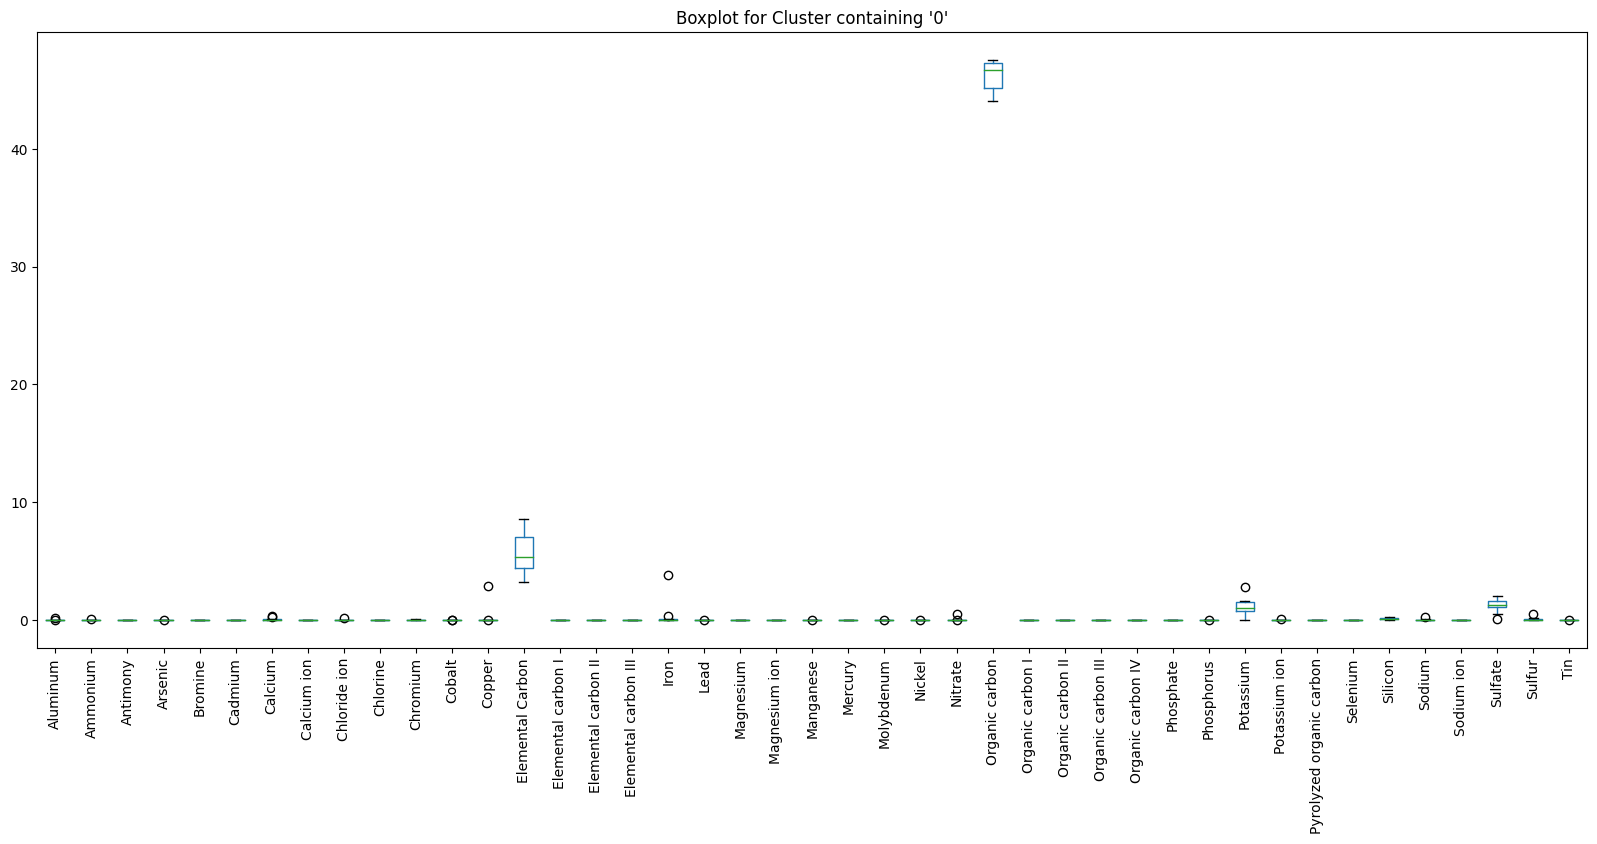

In [47]:
ax = selected_rows.iloc[:, 2:45].boxplot(figsize=(20, 8), grid=False)  # grid=False removes grid
ax.grid(False)

plt.title(f"Boxplot for Cluster containing '{elem}'")
plt.xticks(rotation=90)  # Rotate x-labels if needed
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, NMF

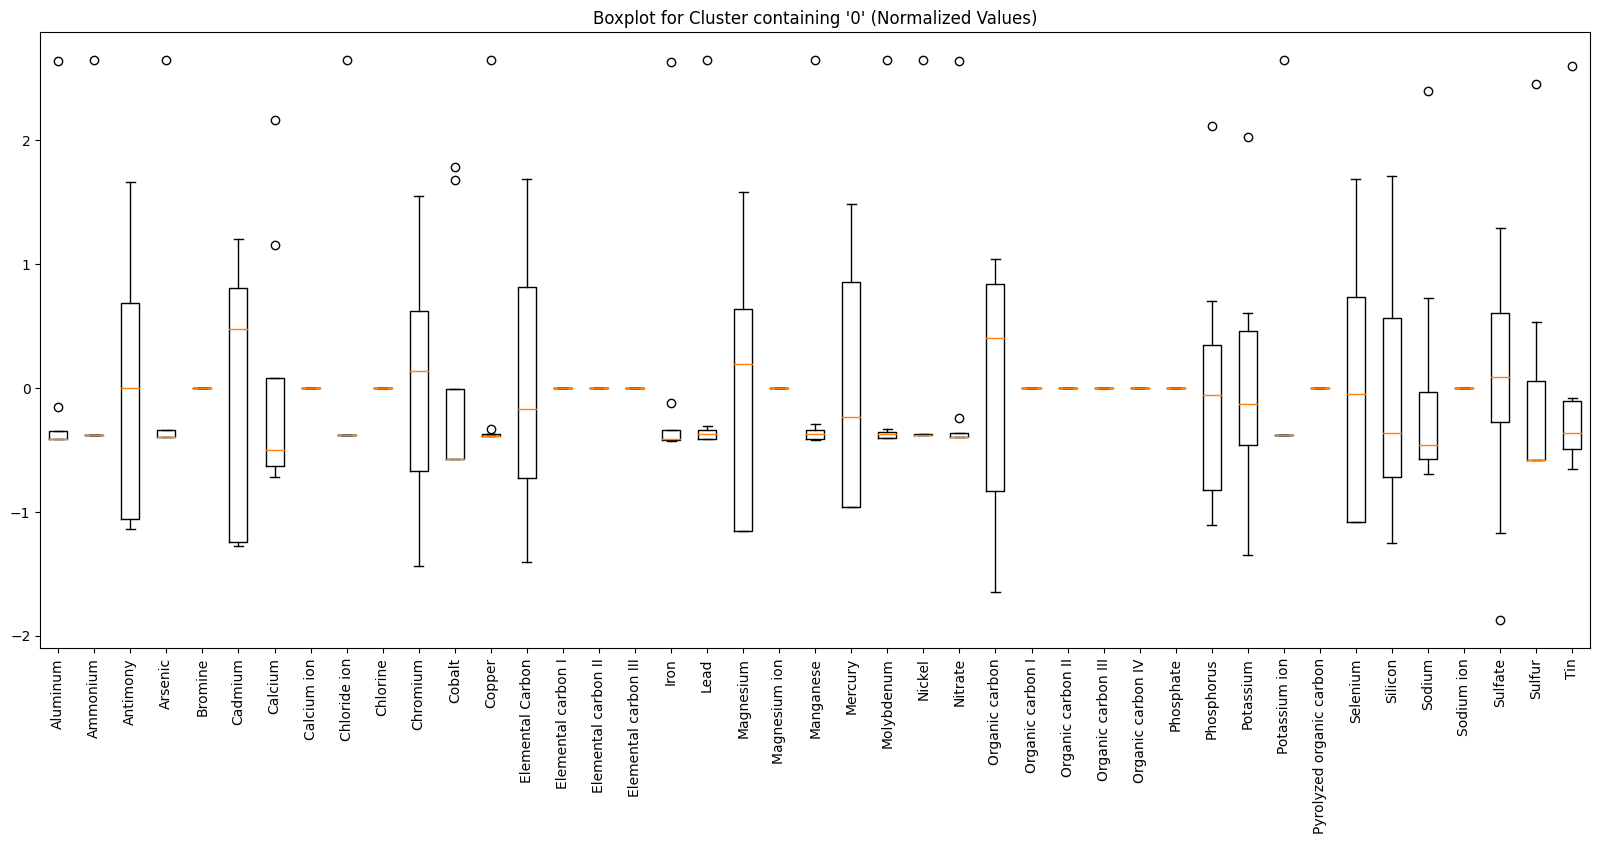

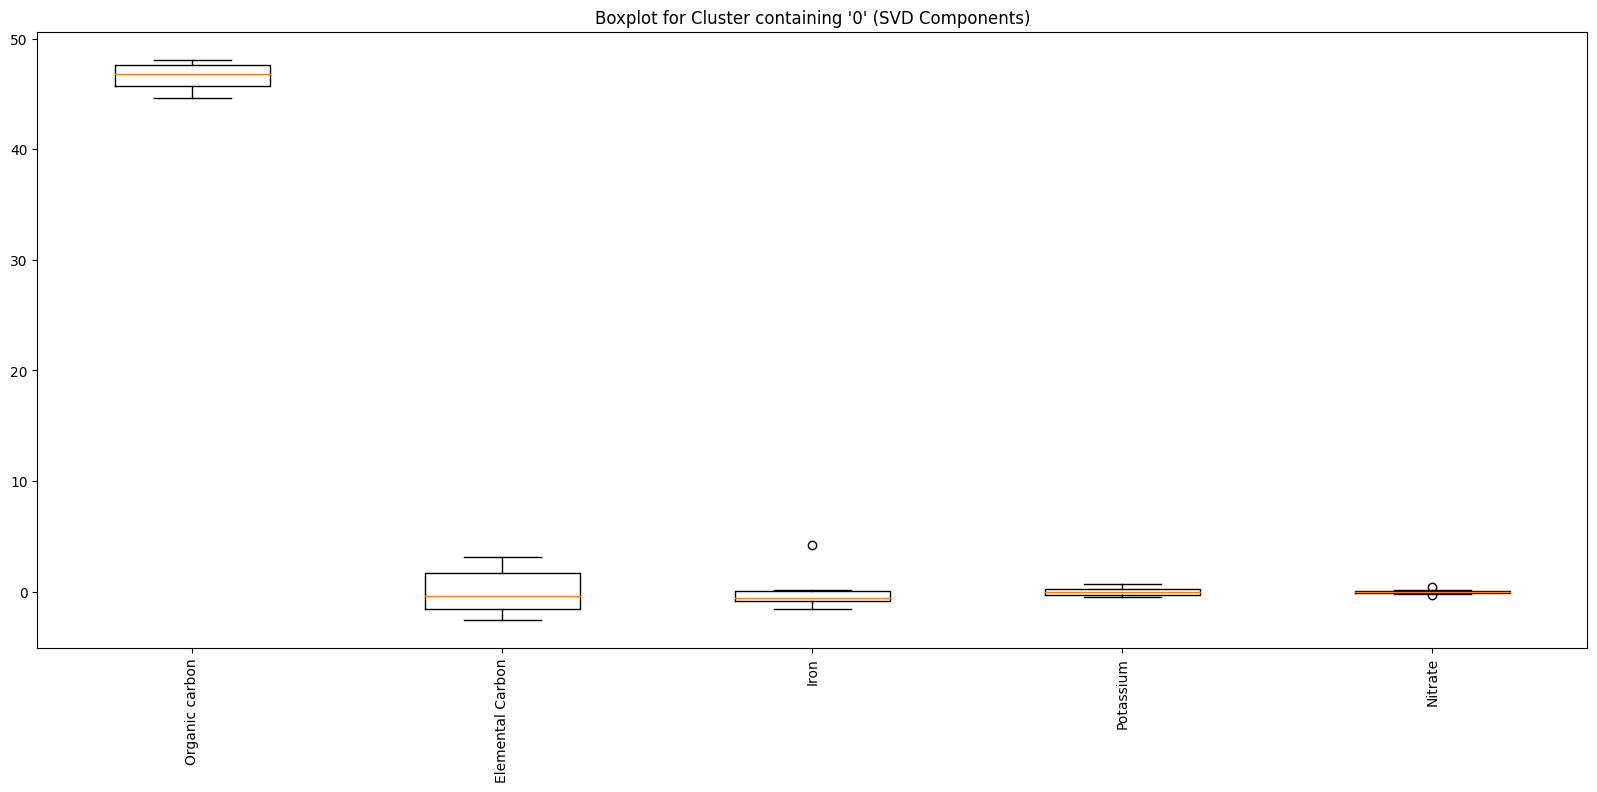

In [49]:
# Normalize the values
scaler = StandardScaler()
normalized_data = scaler.fit_transform(selected_rows.iloc[:, 2:45])

# Create the first box plot with normalized values
fig, ax = plt.subplots(figsize=(20, 8))
ax.boxplot(normalized_data)
ax.grid(False)
ax.set_xticklabels(selected_rows.columns[2:45], rotation=90)
plt.title(f"Boxplot for Cluster containing '{elem}' (Normalized Values)")
plt.xticks(rotation=90)
plt.show()

# Use SVD to find important components
svd = TruncatedSVD(n_components=5)
svd_data = svd.fit_transform(selected_rows.iloc[:, 2:45])

# Get the most important columns based on SVD components
important_columns_svd = selected_rows.columns[2:45][svd.components_.argmax(axis=1)]

# Create the second box plot with SVD components
fig, ax = plt.subplots(figsize=(20, 8))
ax.boxplot(svd_data)
ax.grid(False)
plt.title(f"Boxplot for Cluster containing '{elem}' (SVD Components)")
ax.set_xticklabels(important_columns_svd, rotation=90)
plt.show()

# # Use NMF to find important components
# nmf = NMF(n_components=5)
# nmf_data = nmf.fit_transform(selected_rows.iloc[:, 2:45])

# # Get the most important columns based on NMF components
# important_columns_nmf = selected_rows.columns[2:45][nmf.components_.argmax(axis=1)]

# # Create the third box plot with NMF components
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.boxplot(nmf_data)
# ax.grid(False)
# plt.title(f"Boxplot for Cluster containing '{elem}' (NMF Components)")
# ax.set_xticklabels(important_columns_nmf, rotation=90)
# plt.show()


In [50]:
# # Initialize NMF and fit to the data
# model = NMF(n_components=2, init='random', random_state=0)
# W = model.fit_transform(X)
# H = model.components_

# # Visualize the data
# plt.scatter(W[:, 0], W[:, 1], c=y)
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('NMF Components')
# plt.colorbar()
# plt.show()